A key characteristic of time-series data is their sequential order: rather than random samples of individual observations as in the case of cross-sectional data, our data are a single realization of a stochastic process that we cannot repeat.

## Goal

- to identify systematic patterns in time series that help us predict how the time series will behave in the future
- extract signals from a historical sequence of the output and, optionally, other contemporaneous or lagged input variables to predict future values of the output
- try to predict future returns for a stock using past returns, combined with historical returns of a benchmark or macroeconomic variables
- study nonlinear models like recurrent or convolutional neural networks 
- How to use time series analysis to diagnose diagnostic statistics that inform the modeling process
- How to estimate and diagnose autoregressive and moving-average time series models
- How to build Autoregressive Conditional Heteroskedasticity (ARCH) models to predict volatility
- How to build vector autoregressive models
- How to use cointegration for a pairs trading strategy

## Setup

In [3]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import Utils as utils
import numpy as np
import pandas_datareader.data as web
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import probplot, moment
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.tsa.api as tsa
import pandas as pd

sns.set_style('whitegrid')


## Monthly Industrial Production and NASDAQ stock market index

In [15]:
industrial_production = web.DataReader('IPGMFN', 'fred', '1990', '2020-12').squeeze().dropna()
nasdaq = web.DataReader('NASDAQCOM', 'fred', '1990', '2020-12-31').squeeze().dropna()

In [16]:
industrial_production, nasdaq

(DATE
 1990-01-01    56.8186
 1990-02-01    58.6632
 1990-03-01    59.5400
 1990-04-01    58.5536
 1990-05-01    59.4875
                ...   
 2020-08-01    95.9153
 2020-09-01    94.7903
 2020-10-01    97.2215
 2020-11-01    96.5861
 2020-12-01    96.0263
 Name: IPGMFN, Length: 372, dtype: float64,
 DATE
 1990-01-02      459.33
 1990-01-03      460.90
 1990-01-04      459.39
 1990-01-05      458.22
 1990-01-08      458.71
                 ...   
 2020-12-24    12804.73
 2020-12-28    12899.42
 2020-12-29    12850.22
 2020-12-30    12870.00
 2020-12-31    12888.28
 Name: NASDAQCOM, Length: 7813, dtype: float64)

## Additive Decomposition

Time series data typically contains a mix of various patterns that can be decomposed into several components, each representing an underlying pattern category. In particular, time series often consist of the systematic components trend, seasonality and cycles, and unsystematic noise. These components can be combined in an additive, linear model, in particular when fluctuations do not depend on the level of the series, or in a non-linear, multiplicative model.

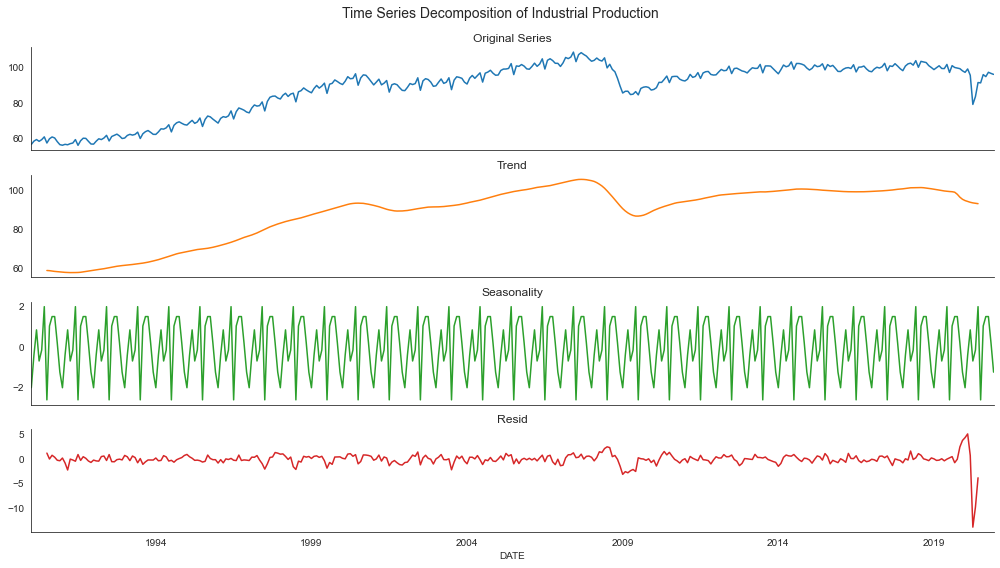

In [17]:
componentsIP = tsa.seasonal_decompose(industrial_production,model = 'additive') # another option for model is 'multiplicative'

ts = (industrial_production.to_frame('Original')
      .assign(Trend=componentsIP.trend)
      .assign(Seasonality=componentsIP.seasonal)
      .assign(Residual=componentsIP.resid))

with sns.axes_style('white'):
    ts.plot(subplots=True,figsize=(14,8),title=['Original Series','Trend','Seasonality','Resid'],legend = False)
    plt.suptitle('Time Series Decomposition of Industrial Production',fontsize = 14)
    sns.despine()
    plt.tight_layout()
    plt.subplots_adjust(top=.91)

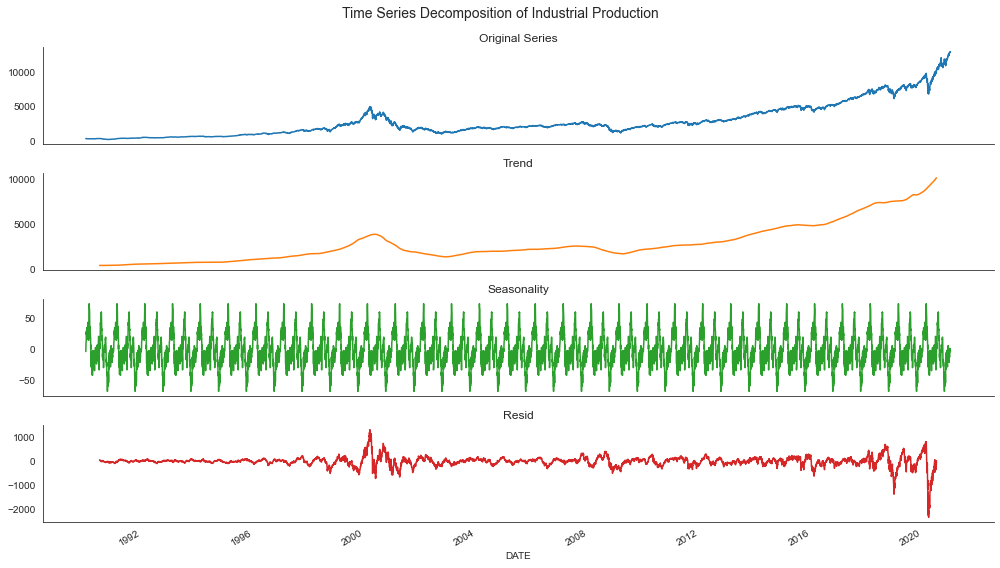

In [18]:
componentsNA = tsa.seasonal_decompose(nasdaq,model = 'additive',period=252) # another option for model is 'multiplicative'

ts = (nasdaq.to_frame('Original')
      .assign(Trend=componentsNA.trend)
      .assign(Seasonality=componentsNA.seasonal)
      .assign(Residual=componentsNA.resid))

with sns.axes_style('white'):
    ts.plot(subplots=True,figsize=(14,8),title=['Original Series','Trend','Seasonality','Resid'],legend = False)
    plt.suptitle('Time Series Decomposition of Industrial Production',fontsize = 14)
    sns.despine()
    plt.tight_layout()
    plt.subplots_adjust(top=.91)

## Stationarity

The statistical properties, such as the mean, variance, or autocorrelation, of a stationary time series are independent of the period, that is, they don't change over time. Hence, stationarity implies that a time series does not have a trend or seasonal effects and that descriptive statistics, such as the mean or the standard deviation, when computed for different rolling windows, are constant or do not change much over time. It reverts to its mean, and the deviations have constant amplitude, while short-term movements always look the same in the statistical sense.

More formally, strict stationarity requires the joint distribution of any subset of time series observations to be independent of time with respect to all moments. So, in addition to the mean and variance, higher moments such as skew and kurtosis, also need to be constant, irrespective of the lag between different observations. In most applications, we limit stationarity to first and second moments so that the time series is covariance stationary with constant mean, variance, and autocorrelation.

Note that we specifically allow for dependence between observations at different lags, just like we want the input data for linear regression to be correlated with the outcome. Stationarity implies that these relationships are stable, which facilitates prediction as the model can focus on learning systematic patterns that take place within stable statistical properties. It is important because classical statistical models assume that the time series input data is stationary.

To satisfy the stationarity assumption of linear time series models, we need to transform the original time series, often in several steps. Common transformations include the application of the (natural) logarithm to convert an exponential growth pattern into a linear trend and stabilize the variance. Deflation implies dividing a time series by another series that causes trending behavior, for example dividing a nominal series by a price index to convert it into a real measure.  

In practice, time series of interest rates or asset prices are often not stationary,
for example, because there does not exist a price level to which the series reverts. The most
prominent example of a non-stationary series is the random walk for a time series of price,
pt, for a given starting price, $p_0$ (for example, a stock's IPO price) and a white-noise
disturbance, $\epsilon$, that satisfies the following:

\begin{equation}
p_t = p_{t-1} + \epsilon_t = \sum_{s=0}^t \epsilon_s + p_0
\end{equation}

If the equation includes a constant
term, then the random walk is said to have drift. Hence, the random walk is an
autoregressive stochastic process of the following form:

\begin{equation}
y_t = a_1 y_{t-1} + \epsilon_t, \textrm{} a_1 = 1
\end{equation}

The augmented Dickey-Fuller (ADF) test evaluates the null hypothesis that a time series
sample has unit root against the alternative of stationarity.

Formally, the ADF test for a time series, $y_t$, runs the linear regression:
\begin{equation}
\Delta y_t = \alpha + \beta t + \gamma y_{t-1} + \delta_1 \Delta y_{t-1} + \cdots + \delta_{p-1}\Delta y_{t-p+1} + \epsilon_t
\end{equation}
Where $\alpha$ is a constant, $\beta$ is a coefficient on a time trend, and $p$ refers to the number of lags
used in the model. The ADF test statistics uses the sample coefficient, γ, that, under the null hypothesis of unitroot
non-stationarity equals zero, and is negative otherwise. It intends to demonstrate that,
for an integrated series, the lagged series value should not provide useful information in
predicting the first difference above and beyond lagged differences.

## Log Transformation

In [19]:
nasdaq_log = utils.log_transform(nasdaq)
industrial_production_log = utils.log_transform(industrial_production)

In [20]:
nasdaq_log,industrial_production_log

(DATE
 1990-01-02    6.129769
 1990-01-03    6.133181
 1990-01-04    6.129900
 1990-01-05    6.127349
 1990-01-08    6.128418
                 ...   
 2020-12-24    9.457570
 2020-12-28    9.464938
 2020-12-29    9.461116
 2020-12-30    9.462654
 2020-12-31    9.464074
 Name: NASDAQCOM, Length: 7813, dtype: float64,
 DATE
 1990-01-01    4.039864
 1990-02-01    4.071813
 1990-03-01    4.086648
 1990-04-01    4.069943
 1990-05-01    4.085766
                 ...   
 2020-08-01    4.563466
 2020-09-01    4.551667
 2020-10-01    4.576992
 2020-11-01    4.570435
 2020-12-01    4.564622
 Name: IPGMFN, Length: 372, dtype: float64)

## Differencing

In many cases, de-trending is not sufficient to make the series stationary. Instead, we need to transform the original data into a series of period-to-period and/or season-to-season differences. In other words, we use the result of subtracting neighboring data points or values at seasonal lags from each other. Note that when such differencing is applied to a log-transformed series, the results represent instantaneous growth rates or returns in a financial context.

If a univariate series becomes stationary after differencing d times, it is said to be integrated of the order of d, or simply integrated if d=1. This behavior is due to so-called unit roots.

Differencing of log series produces instantaneous returns.

In [21]:
nasdaq_log_diff = nasdaq_log.diff().dropna()
industrial_production_log_diff = industrial_production_log.diff(12).dropna()

In [22]:
nasdaq_log_diff,industrial_production_log_diff

(DATE
 1990-01-03    0.003412
 1990-01-04   -0.003282
 1990-01-05   -0.002550
 1990-01-08    0.001069
 1990-01-09   -0.004238
                 ...   
 2020-12-24    0.002629
 2020-12-28    0.007368
 2020-12-29   -0.003821
 2020-12-30    0.001538
 2020-12-31    0.001419
 Name: NASDAQCOM, Length: 7812, dtype: float64,
 DATE
 1991-01-01   -0.008248
 1991-02-01   -0.031068
 1991-03-01   -0.050311
 1991-04-01   -0.022587
 1991-05-01   -0.032256
                 ...   
 2020-08-01   -0.050928
 2020-09-01   -0.052589
 2020-10-01   -0.023676
 2020-11-01   -0.027137
 2020-12-01   -0.020759
 Name: IPGMFN, Length: 360, dtype: float64)

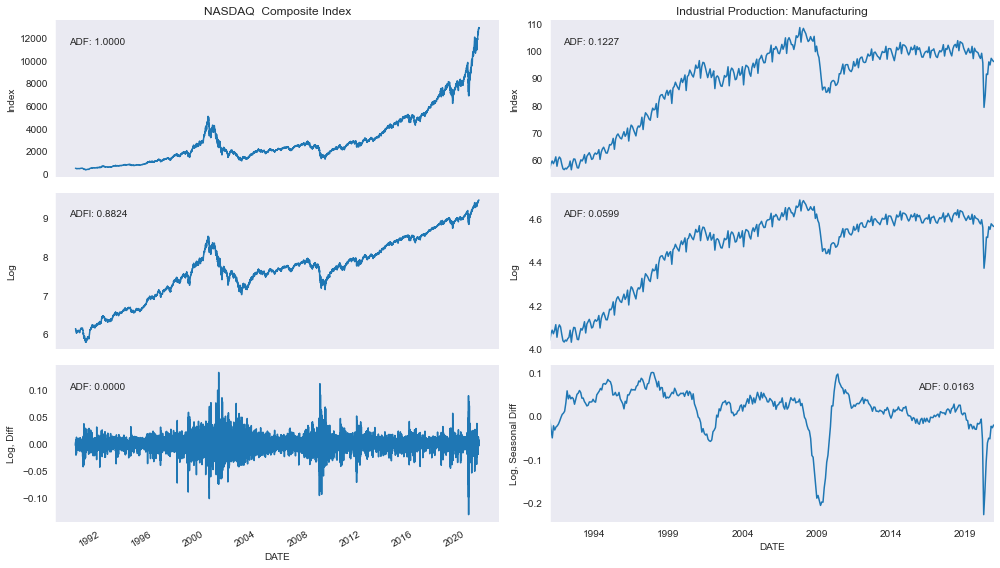

In [23]:
with sns.axes_style('dark'):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 8))

    nasdaq.plot(ax=axes[0][0],
                title='NASDAQ  Composite Index')
    axes[0][0].text(x=.03,
                    y=.85,
                    s=f'ADF: {tsa.adfuller(nasdaq.dropna())[1]:.4f}',
                    transform=axes[0][0].transAxes)
    axes[0][0].set_ylabel('Index')

    nasdaq_log.plot(ax=axes[1][0],
                    sharex=axes[0][0])
    axes[1][0].text(x=.03, y=.85,
                    s=f'ADFl: {tsa.adfuller(nasdaq_log.dropna())[1]:.4f}',
                    transform=axes[1][0].transAxes)
    axes[1][0].set_ylabel('Log')

    nasdaq_log_diff.plot(ax=axes[2][0],
                         sharex=axes[0][0])
    axes[2][0].text(x=.03, y=.85,
                    s=f'ADF: {tsa.adfuller(nasdaq_log_diff.dropna())[1]:.4f}',
                    transform=axes[2][0].transAxes)
    axes[2][0].set_ylabel('Log, Diff')

    industrial_production.plot(ax=axes[0][1],
                               title='Industrial Production: Manufacturing')
    axes[0][1].text(x=.03, y=.85,
                    s=f'ADF: {tsa.adfuller(industrial_production)[1]:.4f}',
                    transform=axes[0][1].transAxes)
    axes[0][1].set_ylabel('Index')

    industrial_production_log.plot(ax=axes[1][1],
                                   sharex=axes[0][1])
    axes[1][1].text(x=.03, y=.85,
                    s=f'ADF: {tsa.adfuller(industrial_production_log.dropna())[1]:.4f}',
                    transform=axes[1][1].transAxes)
    axes[1][1].set_ylabel('Log')

    industrial_production_log_diff.plot(ax=axes[2][1],
                                        sharex=axes[0][1])
    axes[2][1].text(x=.83, y=.85,
                    s=f'ADF: {tsa.adfuller(industrial_production_log_diff.dropna())[1]:.4f}',
                    transform=axes[2][1].transAxes)
    axes[2][1].set_ylabel('Log, Seasonal Diff')
    sns.despine()
    fig.tight_layout()
    fig.align_ylabels(axes)

## Correlogram

Autocorrelation (also called serial correlation) adapts the concept of correlation to the time series context: just as the correlation coefficient measures the strength of a linear relationship between two variables, the autocorrelation coefficient, $\rho_k$, measures the extent of a linear relationship between time series values separated by a given lag, $k$.

Hence, we can calculate one autocorrelation coefficient for each of the T-1 lags in a time series; T is the length of the series. The autocorrelation function (ACF) computes the correlation coefficients as a function of the lag. The autocorrelation for a lag larger than 1 (that is, between observations more than one time step apart) reflects both the direct correlation between these observations and the indirect influence of the intervening data points. The partial autocorrelation removes this influence and only measures the linear dependence between data points at the given lag distance. The partial autocorrelation function (PACF) provides all the correlations that result once the effects of a correlation at shorter lags have been removed. A correlogram is simply a plot of the ACF or PACF for sequential lags, k=0,1,...,n.
It allows us to inspect the correlation structure across lags at one glance. The main usage of correlograms is to detect any autocorrelation after the removal of the effects of deterministic trend or seasonality. Both the ACF and the PACF are key diagnostic tools for the design of linear time series models and we will review examples of ACF and PACF plots in the following section on time series transformations.

Autocorrelation Function:
\begin{equation}
\rho_k = \frac{\sum_{t=k+1}^T (y_t - \bar{y})(y_{t-k} - \bar{y})}{\sum_{t=1}^T(y_t - \bar{y})^2}
\end{equation}

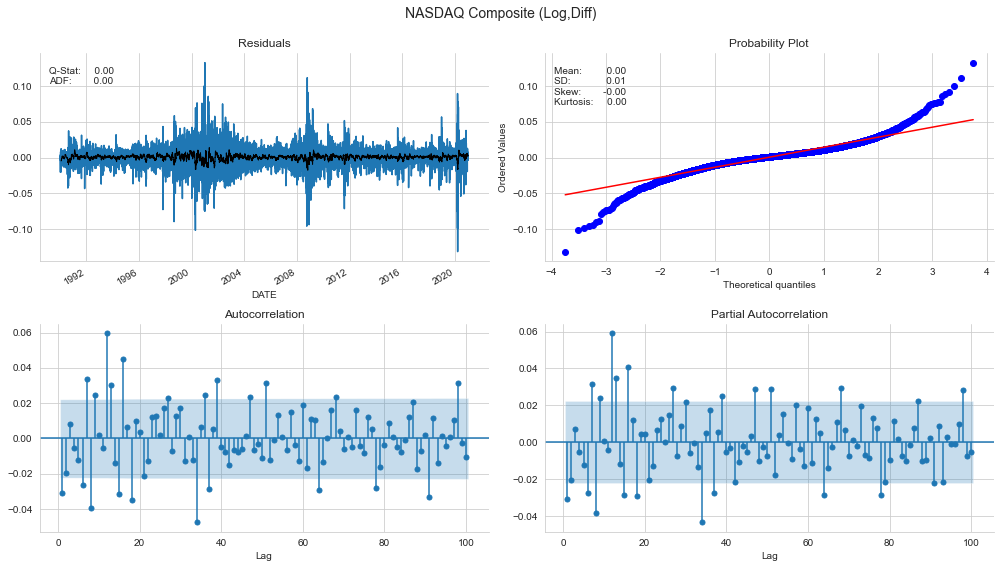

In [24]:
utils.plot_correlogram(nasdaq_log_diff, lags = 100, title='NASDAQ Composite (Log,Diff)')

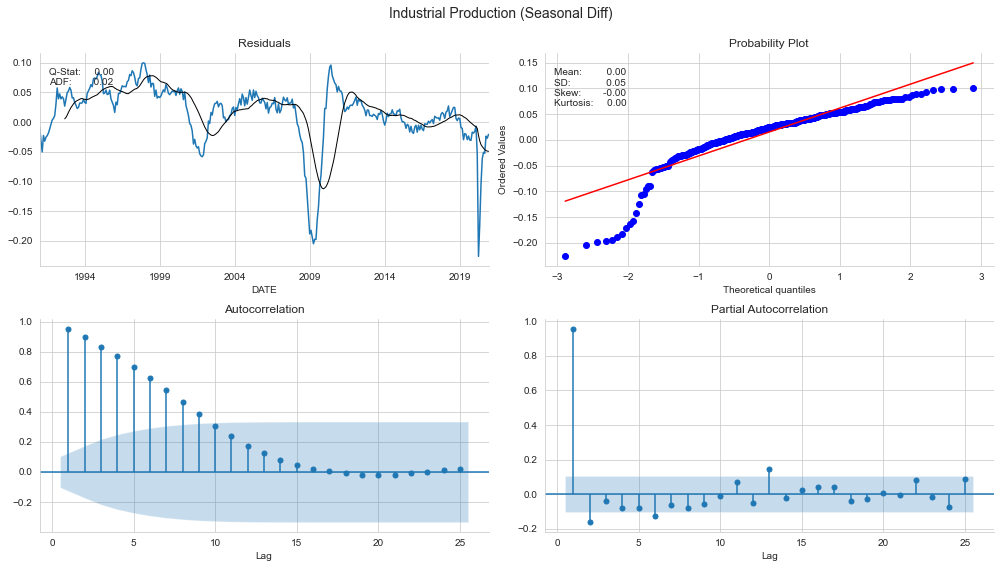

In [25]:
utils.plot_correlogram(industrial_production_log_diff,lags = 25, title='Industrial Production (Seasonal Diff)')

## Univariate Time Series Models

### Autoregressive Integrated Moving Average (ARIMA) Model

Multiple linear-regression models expressed the variable of interest as a linear combination of predictors or input variables. Univariate time series models relate the value of the time series at the point in time of interest to a linear combination of lagged values of the series and possibly past disturbance terms. While exponential smoothing models are based on a description of the trend and seasonality in the data, ARIMA models aim to describe the autocorrelations in the data. ARIMA(p, d, q) models require stationarity and leverage two building blocks:

- Autoregressive (AR) terms consisting of p-lagged values of the time series
\begin{equation}
AR(p): \textrm{} \quad y_t = \phi_0 + \phi_1 y_{t-1} + \cdots + \phi_p y_{t-p} + \epsilon_t, \quad \epsilon \sim i.i.d.
\end{equation}
for an AR model of order k, the ACF will show a significant serial correlation up
to lag k and, due to the inertia caused by the indirect effects of the linear relationship, will
extend to subsequent lags and eventually trail off as the effect was weakened. On the other
hand, the PACF only measures the direct linear relationship between observations a given
lag apart so that it will not reflect correlation for lags beyond k.  
In addition to inspecting the ACF to verify the absence of significant autocorrelation
coefficients, the Ljung-Box Q statistic allows us to test the hypothesis that the residual series
follows white noise. The null hypothesis is that all $m$ serial correlation coefficients are zero
against the alternative that some coefficients are not. The test statistic is computed from the
sample autocorrelation coefficients, $ρ_k$, for different lags, $k$, and follows an $\chi^2$ distribution:
\begin{equation}
Q(m) = T(T+2)\sum_{l=1}^m\frac{\rho_r^2}{T-l}
\end{equation}
- Moving average (MA) terms that contain q-lagged disturbances
\begin{equation}
MA(q): \textrm{} \quad y_t = c + \epsilon_t + \theta_1\epsilon_{t-1} + \theta_2\epsilon_{t-2} + \cdots + \theta_q \epsilon_{t-q}, \quad \epsilon \sim i.i.d.
\end{equation}

The MA(q) model gets its name from representing each value of$y_t$ as a weighted moving
average of the past $q$ innovations. In other words, current estimates represent a correction
relative to past errors made by the model. The use of moving averages in MA(q) models
differs from that of exponential smoothing or the estimation of seasonal time series
components because an MA(q) model aims to forecast future values as opposed to denoising
or estimating the trend cycle of past values.

The $I$ stands for integrated because the model can account for unit-root non-stationarity by
differentiating the series d times. The term autoregression underlines that ARIMA models
imply a regression of the time series on its own values. A time series generated by an MA(q) process is driven by the residuals from the q priormodel
predictions. Hence, the ACF for the MA(q) process will show significant coefficients
for values up to the lag, q, and then decline sharply because this is how the series values are
assumed to have been generated.

An AR(p) model can be expressed as an MA(∞) process using repeated substitution. When
imposing constraints on the size of its coefficients, an MA(q) process, it becomes invertible
and can be expressed as an AR(∞) process.

Autoregressive integrated moving-average ARIMA(p, d, q) models combine AR(p) and
MA(q) processes to leverage the complementarity of these building blocks and simplify
model development by using a more compact form and reducing the number of
parameters, in turn reducing the risk of overfitting.

The models also take care of eliminating unit-root nonstationarity by using the dth
difference of the time series values. An ARIMA(p, 1, q) model is the same as using an
ARMA(p, q) model with the first differences of the series. Using $y'$ to denote the original
series after non-seasonal differencing d times, the ARIMA(p, d, q) model is simply:
\begin{equation}
ARIMA(p,d,q): \textrm{} \quad y_t = AR(p) + MA(q) = \phi_0 + \phi_1 y_{t-1} + \cdots + \phi_p y_{t-p} + \epsilon_t + \theta_1\epsilon_{t-1} + \theta_2\epsilon_{t-2} + \cdots + \theta_q \epsilon_{t-q}, \quad \epsilon \sim i.i.d.
\end{equation}

Since AR(p) and MA(q) terms interact, the information provided by the ACF and PACF is
no longer reliable and can only be used as a starting point.
Traditionally, the AIC and BIC information criteria have been used to rely on in-sample fit
when selecting the model design. Alternatively, we can rely on out-of-sample tests to crossvalidate
multiple parameter choices.
The following summary provides some generic guidance to choose the model order in the
case of considering AR and MA models in isolation:
- The lag beyond which the PACF cuts off is the indicated number of AR terms. If
the PACF of the differenced series cuts off sharply and/or the lag-1
autocorrelation is positive, add one or more AR terms.
- The lag beyond which the ACF cuts off is the indicated number of MA terms. If
the ACF of the differenced series displays a sharp cutoff and/or the lag-1
autocorrelation is negative, consider adding an MA term to the model.
- AR and MA terms may cancel out each other's effects, so always try to reduce the
number of AR and MA terms by 1 if your model contains both to avoid
overfitting, especially if the more complex model requires more than 10 iterations
to converge.
- If the AR coefficients sum to nearly 1 and suggest a unit root in the AR part of the
model, eliminate 1 AR term and difference the model once (more).
- If the MA coefficients sum to nearly 1 and suggest a unit root in the MA part of
the model, eliminate 1 MA term and reduce the order of differencing by 1.
- Unstable long-term forecasts suggest there may be a unit root in the AR or MA
part of the model.


An ARMAX model adds input variables or covariate on the right-hand side of the ARMA
time series model (assuming the series is stationary so we can skip differencing):
\begin{equation}
ARIMA(p,d,q): \textrm{} \quad y_t = \beta x_t + AR(p) + MA(q) = \beta x_t \phi_0 + \phi_1 y_{t-1} + \cdots + \phi_p y_{t-p} + \epsilon_t + \theta_1\epsilon_{t-1} + \theta_2\epsilon_{t-2} + \cdots + \theta_q \epsilon_{t-q}, \quad \epsilon \sim i.i.d.
\end{equation}

For time series with seasonal effects, we can include AR and MA terms that capture the
seasonality's periodicity. For instance, when using monthly data and the seasonal effect
length is one year, the seasonal AR and MA terms would reflect this particular lag length.
The ARIMAX(p, d, q) model then becomes a SARIMAX(p, d, q) x (P, D, Q)s model, which is
a bit more complicated to write out,

## ARMA vs ARIMA

The ARMA model of the undifferenced series produces the same result as the ARIMA model of the differenced series.

In [26]:
model1 = tsa.ARMA(endog = nasdaq_log_diff,order=(2,2)).fit()
model2 = tsa.ARMA(endog = nasdaq_log, order=(2,1,2)).fit()

In [27]:
model1.params

const              0.000427
ar.L1.NASDAQCOM   -0.622514
ar.L2.NASDAQCOM   -0.945734
ma.L1.NASDAQCOM    0.603146
ma.L2.NASDAQCOM    0.930497
dtype: float64

In [28]:
model2.params

const              7.780023
ar.L1.NASDAQCOM    1.432153
ar.L2.NASDAQCOM   -0.432177
ma.L1.NASDAQCOM   -0.462912
dtype: float64

## Seasonal differencing vs SARIMAX

In [29]:
model1_SARIMAX = tsa.statespace.SARIMAX(industrial_production_log,order=(2,0,2),seasonal_order=(0,1,0,12)).fit()
model2_diff = tsa.statespace.SARIMAX(industrial_production_log_diff, order=(2,0,2), seasonal_order=(0,0,0,12)).fit()

In [30]:
model2_diff.params

ar.L1     0.266566
ar.L2     0.643442
ma.L1     0.817787
ma.L2     0.076827
sigma2    0.000226
dtype: float64

In [31]:
model1_SARIMAX.params

ar.L1     0.261598
ar.L2     0.651146
ma.L1     0.824430
ma.L2     0.074847
sigma2    0.000226
dtype: float64

In [32]:
model2_diff.params.to_frame('diff').join(model1_SARIMAX.params.to_frame('SARIMAX'))

,diff,SARIMAX
ar.L1,0.266566,0.261598
ar.L2,0.643442,0.651146
ma.L1,0.817787,0.824430
ma.L2,0.076827,0.074847
sigma2,0.000226,0.000226


In [33]:
#results = utils.optimal_ARMA_lags(120,3,3,industrial_production_log_diff)

ARMA(0,1) is being tested
ARMA(0,2) is being tested
ARMA(1,0) is being tested
ARMA(1,1) is being tested
ARMA(1,2) is being tested
ARMA(2,0) is being tested
ARMA(2,1) is being tested
ARMA(2,2) is being tested


In [34]:
#results

RMSE         AIC         BIC  convergence  stationarity
p q                                                              
0 1   0.033459 -522.366641 -514.004165          0.0           0.0
  2   0.100923 -578.979430 -567.829463          0.0         117.0
1 0   0.017251 -719.231605 -710.869130          0.0           0.0
  1   0.032896 -725.149072 -713.999105          0.0          17.0
  2   0.026538 -737.358727 -723.421268          0.0          12.0
2 0  18.064769 -716.885067 -705.735100          0.0           0.0
  1   0.034501 -742.373091 -728.435632          8.0          17.0
  2   0.019217 -752.889486 -736.164536          1.0           5.0

In [35]:
#results.nsmallest(5,columns=['RMSE'])

RMSE         AIC         BIC  convergence  stationarity
p q                                                             
1 0  0.017251 -719.231605 -710.869130          0.0           0.0
2 2  0.019217 -752.889486 -736.164536          1.0           5.0
1 2  0.026538 -737.358727 -723.421268          0.0          12.0
  1  0.032896 -725.149072 -713.999105          0.0          17.0
0 1  0.033459 -522.366641 -514.004165          0.0           0.0

In [36]:
#results.nsmallest(5,columns=['BIC'])

RMSE         AIC         BIC  convergence  stationarity
p q                                                             
2 2  0.019217 -752.889486 -736.164536          1.0           5.0
  1  0.034501 -742.373091 -728.435632          8.0          17.0
1 2  0.026538 -737.358727 -723.421268          0.0          12.0
  1  0.032896 -725.149072 -713.999105          0.0          17.0
  0  0.017251 -719.231605 -710.869130          0.0           0.0

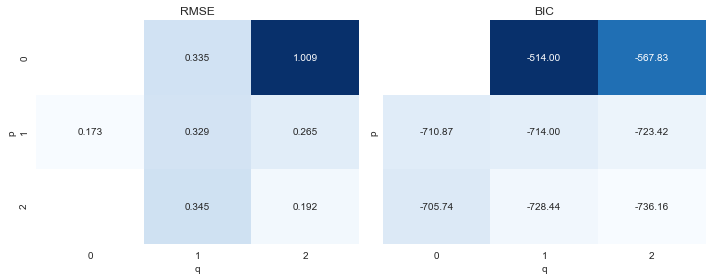

In [37]:
#fig,axes = plt.subplots(ncols=2,figsize=(10,4),sharex=True,sharey=True)
#sns.heatmap(results[results.RMSE<.5].RMSE.unstack().mul(10),fmt='.3f',annot=True,cmap='Blues',ax=axes[0],cbar=False)
#sns.heatmap(results.BIC.unstack(),fmt='.2f',annot=True,cmap='Blues',ax=axes[1],cbar=False)
#axes[0].set_title('RMSE')
#axes[1].set_title('BIC')
#fig.tight_layout()

### The best ARMA model would be ARMA(1,0)

In [38]:
best_arma_model = tsa.ARMA(endog=industrial_production_log_diff,order=(1,0)).fit()
print(best_arma_model.summary())

                              ARMA Model Results                              
Dep. Variable:                 IPGMFN   No. Observations:                  360
Model:                     ARMA(1, 0)   Log Likelihood                 995.714
Method:                       css-mle   S.D. of innovations              0.015
Date:                Sun, 10 Oct 2021   AIC                          -1985.427
Time:                        19:37:22   BIC                          -1973.769
Sample:                    01-01-1991   HQIC                         -1980.792
                         - 12-01-2020                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0122      0.016      0.765      0.445      -0.019       0.043
ar.L1.IPGMFN     0.9524      0.015     61.834      0.000       0.922       0.983
                                    Roots   

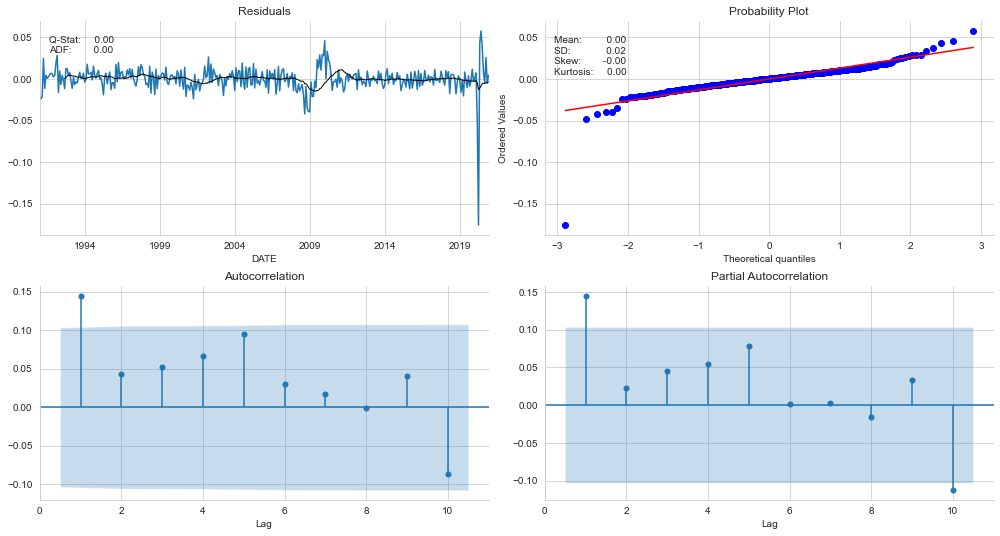

In [39]:
utils.plot_correlogram(best_arma_model.resid)

### SARIMAX model for monthly data on an industrial production time series for the 1990-2020 period

the data has been log-transformed, and we are using seasonal (lag-12) differences. We estimate the model for a range of both ordinary and conventional AR and MA parameters using a rolling window of 10 years of training data, and evaluate the RMSE of the 1-step-ahead forecast.

In [40]:
sarimax_model = tsa.SARIMAX(endog=industrial_production_log_diff.dropna().values,
                    order=(2, 0, 2),
                    seasonal_order=(1, 0, 1, 12)).fit(start_params=[0, 0, 0, 0, 0, 0, 1])
print(sarimax_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  360
Model:             SARIMAX(2, 0, 2)x(1, 0, [1], 12)   Log Likelihood                1017.333
Date:                              Sun, 10 Oct 2021   AIC                          -2020.666
Time:                                      19:37:24   BIC                          -1993.463
Sample:                                           0   HQIC                         -2009.850
                                              - 360                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1202      0.073      1.650      0.099      -0.023       0.263
ar.L2          0.87

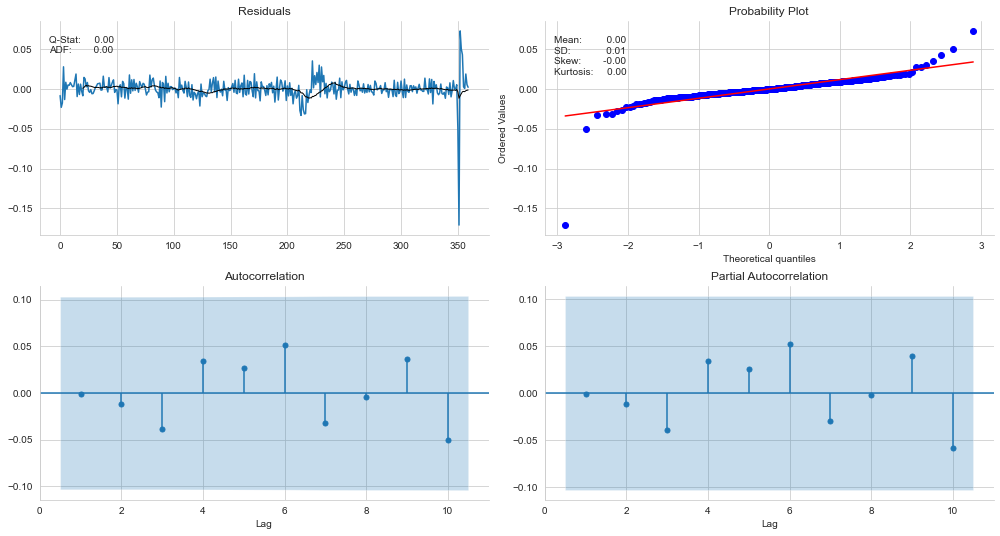

In [41]:
utils.plot_correlogram(pd.Series(sarimax_model.resid))

In [49]:
#sarimax_result = utils.optimal_sarimax_lags(120,industrial_production_log_diff)

  0%|          | 0/16 [00:00<?, ?it/s]

SARIMAX(1,1,0,0) is being tested


  6%|▋         | 1/16 [00:11<02:50, 11.34s/it]

SARIMAX(1,1,0,1) is being tested


 12%|█▎        | 2/16 [00:56<07:14, 31.03s/it]

SARIMAX(1,1,1,0) is being tested


 19%|█▉        | 3/16 [01:33<07:18, 33.73s/it]

SARIMAX(1,1,1,1) is being tested


 25%|██▌       | 4/16 [02:43<09:37, 48.10s/it]

SARIMAX(1,2,0,0) is being tested


 31%|███▏      | 5/16 [03:05<07:07, 38.89s/it]

SARIMAX(1,2,0,1) is being tested


 38%|███▊      | 6/16 [04:14<08:10, 49.10s/it]

SARIMAX(1,2,1,0) is being tested


 44%|████▍     | 7/16 [05:17<08:03, 53.68s/it]

SARIMAX(1,2,1,1) is being tested


 50%|█████     | 8/16 [06:41<08:26, 63.36s/it]

SARIMAX(2,1,0,0) is being tested


 56%|█████▋    | 9/16 [07:24<06:37, 56.82s/it]

SARIMAX(2,1,0,1) is being tested


 62%|██████▎   | 10/16 [08:49<06:33, 65.62s/it]

SARIMAX(2,1,1,0) is being tested


 69%|██████▉   | 11/16 [10:01<05:37, 67.51s/it]

SARIMAX(2,1,1,1) is being tested


 75%|███████▌  | 12/16 [11:41<05:09, 77.48s/it]

SARIMAX(2,2,0,0) is being tested


 81%|████████▏ | 13/16 [12:09<03:07, 62.36s/it]

SARIMAX(2,2,0,1) is being tested


 88%|████████▊ | 14/16 [13:25<02:13, 66.61s/it]

SARIMAX(2,2,1,0) is being tested


 94%|█████████▍| 15/16 [14:31<01:06, 66.50s/it]

SARIMAX(2,2,1,1) is being tested


100%|██████████| 16/16 [16:12<00:00, 60.76s/it]


In [51]:
#sarimax_result

RMSE  RMSE_std         AIC    AIC_std         BIC    BIC_std  \
p1 q1 p2 q2                                                                     
1  1  0  0   0.018942  0.002372 -723.705976  42.092954 -715.343501  42.092954   
         1   0.018267  0.002510 -749.978846  47.305376 -738.828879  47.305376   
      1  0   0.018592  0.002541 -740.416961  39.294773 -729.266994  39.294773   
         1   0.018091  0.002484 -751.943985  39.460372 -738.006526  39.460372   
   2  0  0   0.019431  0.002625 -736.848406  42.970963 -725.698439  42.970963   
         1   0.018854  0.002723 -757.289097  47.260405 -743.351638  47.260405   
      1  0   0.019276  0.002766 -749.777766  41.083160 -735.840307  41.083160   
         1   0.018835  0.002675 -758.827074  40.934811 -742.102123  40.934811   
2  1  0  0   0.020046  0.002718 -720.810717  44.625505 -709.660750  44.625505   
         1   0.020426  0.003253 -748.149596  47.623241 -734.212137  47.623241   
      1  0   0.017157  0.002292 -736.969095  40.747095 -723.031636  40.747095   
         1   0.019764  0.003004 -750.232641  42.072644 -733.507691  42.072644   
   2  0  0   0.018482  0.002506 -752.157787  34.844131 -738.220329  34.844131   
         1   0.018915  0.002785 -766.039831  44.775394 -749.314881  44.775394   
      1  0   0.018551  0.002694 -764.237994  35.268831 -747.513044  35.268831   
         1   0.018414  0.002714 -770.258870  37.124885 -750.746427  37.124885   

             convergence  stationarity        CV  
p1 q1 p2 q2                                       
1  1  0  0           0.0           0.0  0.125213  
         1           0.0           0.0  0.137412  
      1  0           0.0           0.0  0.136666  
         1           0.0           0.0  0.137298  
   2  0  0           0.0           0.0  0.135098  
         1           0.0           0.0  0.144419  
      1  0           0.0           0.0  0.143485  
         1           0.0           0.0  0.142009  
2  1  0  0           0.0           0.0  0.135597  
         1           0.0           0.0  0.159251  
      1  0           0.0           0.0  0.133614  
         1           0.0           0.0  0.152011  
   2  0  0           0.0           0.0  0.135582  
         1           0.0           0.0  0.147226  
      1  0           0.0           0.0  0.145223  
         1           0.0           0.0  0.147407

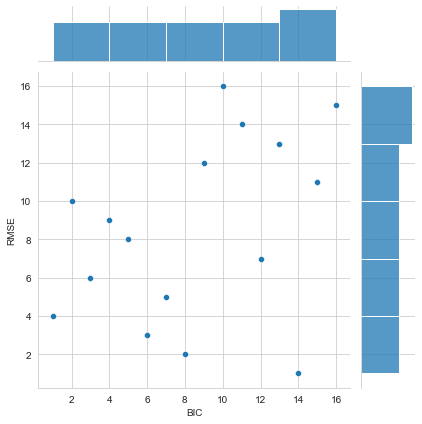

In [52]:
#sns.jointplot(y='RMSE', x='BIC', data=sarimax_result[['RMSE', 'BIC']].rank());

In [53]:
#sarimax_result[['RMSE', 'AIC', 'BIC']].corr('spearman')

,RMSE,AIC,BIC
RMSE,1.000000,0.370588,0.367647
AIC,0.370588,1.000000,0.961765
BIC,0.367647,0.961765,1.000000


In [54]:
#sarimax_result[['RMSE', 'AIC', 'BIC']].sort_values('RMSE').head()

RMSE         AIC         BIC
p1 q1 p2 q2                                  
2  1  1  0   0.017157 -736.969095 -723.031636
1  1  1  1   0.018091 -751.943985 -738.006526
      0  1   0.018267 -749.978846 -738.828879
2  2  1  1   0.018414 -770.258870 -750.746427
      0  0   0.018482 -752.157787 -738.220329

### The best model SARIMAX(2,0,3) $\times$ (1,0,0)

In [42]:
p1,q1,p2,q2 = 2,3,1,2

In [43]:
best_model = tsa.SARIMAX(endog=industrial_production_log_diff.values, order=(p1, 0, q1),
                         seasonal_order=(p2, 0, q2, 12)).fit()


print(best_model.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  360
Model:             SARIMAX(2, 0, 3)x(1, 0, [1, 2], 12)   Log Likelihood                1014.201
Date:                                 Sun, 10 Oct 2021   AIC                          -2010.401
Time:                                         19:37:26   BIC                          -1975.426
Sample:                                              0   HQIC                         -1996.494
                                                 - 360                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8970      0.091     20.763      0.000       1.718       2

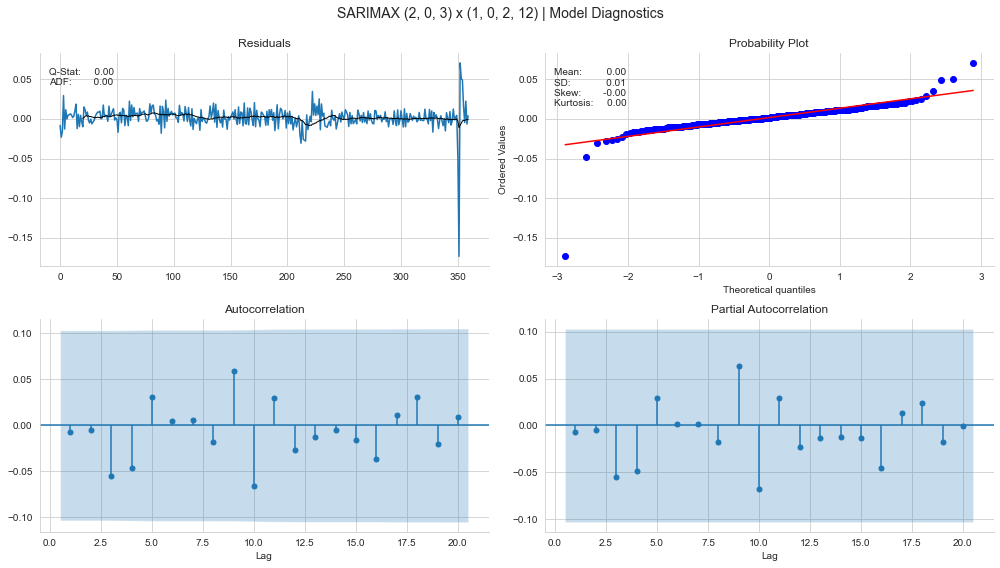

In [44]:
utils.plot_correlogram(pd.Series(best_model.resid),
                 lags=20,
                 title=f'SARIMAX ({p1}, 0, {q1}) x ({p2}, 0, {q2}, 12) | Model Diagnostics')

## ARCH/GARCH Volatility Forecasting

The development of a volatility model for an asset-return series consists of four steps:

- Build an ARMA time series model for the financial time series based on the serial dependence revealed by the ACF and PACF.
- Test the residuals of the model for ARCH/GARCH effects, again relying on the ACF and PACF for the series of the squared residual.
- Specify a volatility model if serial correlation effects are significant, and jointly estimate the mean and volatility equations.
- Check the fitted model carefully and refine it if necessary
When applying volatility forecasting to return series, the serial dependence may be limited so that a constant mean may be used instead of an ARMA model.

The mean models can be jointly defined and estimated with several conditional heteroskedasticity models that include, in addition to ARCH and GARCH, the exponential GARCH (EGARCH) model, which allows for asymmetric effects between positive and negative returns and the heterogeneous ARCH (HARCH) model, which complements the HAR mean model.

\begin{equation}
ARCH(p): var(x_t) = \sigma_t^2 = \omega + \alpha_1\epsilon_{t-1}^2 + \cdots + \alpha_p \epsilon_{t-p}^2, \quad \epsilon_t = \sigma_t z_t, \quad z_t \sim i.i.d.
\end{equation}

One strength of the model is that it produces volatility, estimates positive excess
kurtosis—that is, fat tails relative to the normal distribution—which in turn is in line with
empirical observations about returns. Weaknesses include that the model assumes the same
effect for positive and negative volatility shocks because it depends on the square of the
previous shocks, whereas asset prices are known to respond differently to positive and
negative shocks. The ARCH model also does not offer new insight into the source of
variations of a financial time series because it just mechanically describes the conditional
variance. Finally, ARCH models are likely to overpredict the volatility because they
respond slowly to large, isolated shocks to the return series.

\begin{equation}
ARCH(p): \sigma_t^2 = \omega + \sum_{i=1}^p \alpha_i\epsilon_{t-i}^2 + \sum_{j=1}^q\beta_j \sigma_{t-j}^2, \quad \epsilon_t = \sigma_t z_t, \quad z_t \sim i.i.d.
\end{equation}

The GARCH(p, q) model assumes an ARMA(p, q) model for the variance of the error
term, $\epsilon_t$.

In [45]:
nasdaq_returns = np.log(nasdaq).diff().dropna().mul(100)

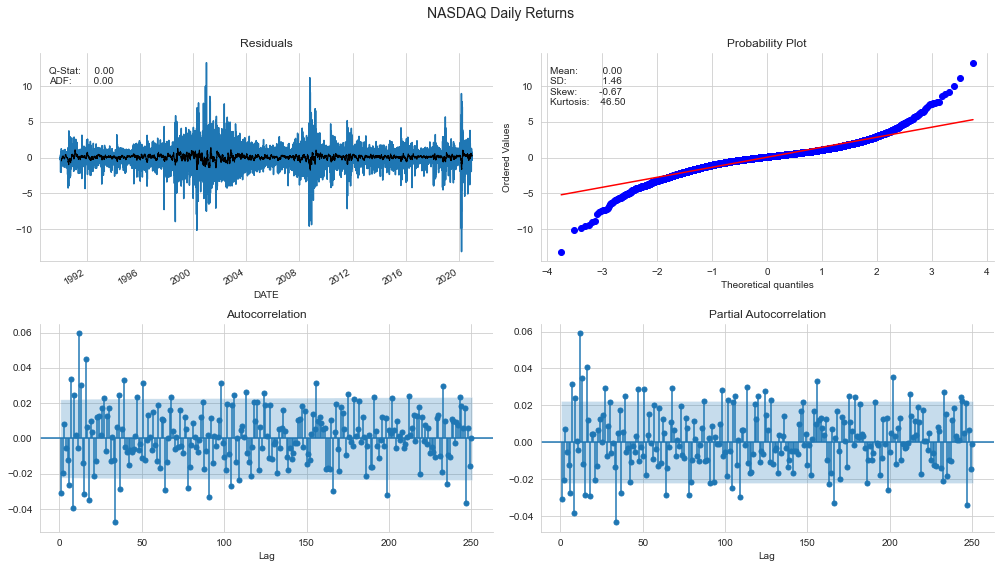

In [46]:
utils.plot_correlogram(nasdaq_returns, lags=250, title='NASDAQ Daily Returns')

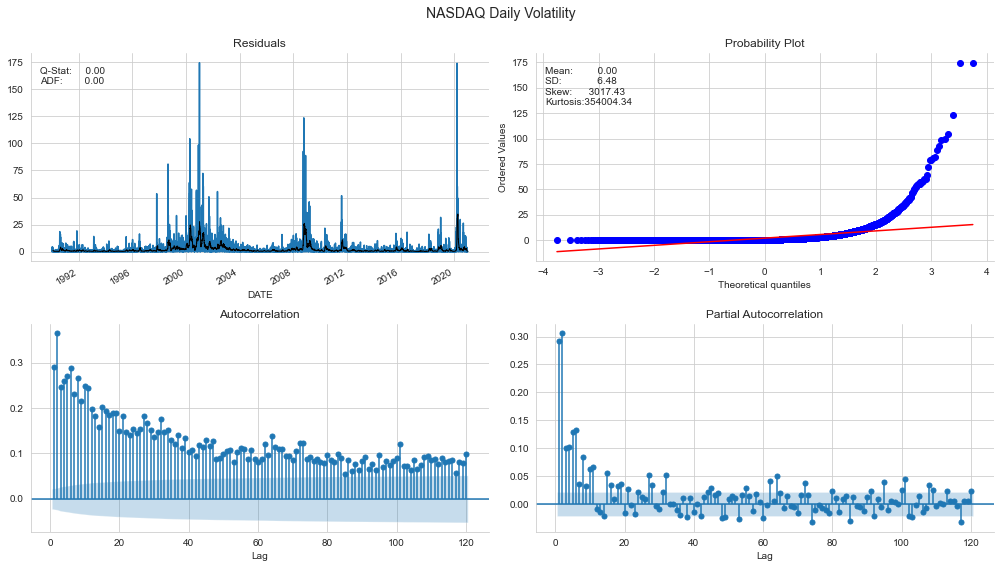

In [47]:
utils.plot_correlogram(nasdaq_returns.sub(nasdaq_returns.mean()).pow(2), lags=120, title='NASDAQ Daily Volatility')

The rescaled daily return series exhibits only limited autocorrelation, but the squared deviations from the mean do have substantial memory reflected in the slowly-decaying ACF and the PACF high for the first two and cutting off only after the first six lags

In [50]:
#garch_resutl = utils.optimal_GARCH(10,nasdaq_returns,3,3)

1 | 1
1 | 2
2 | 1
2 | 2


In [51]:
#garch_resutl

{(1, 1): 1.554462164693519,
 (1, 2): 1.5542186078962306,
 (2, 1): 1.5541777063300672,
 (2, 2): 1.5547367876928975}

### Estimate GARCH(2,1)

In [52]:
best_p , best_q = 2,1

In [58]:
from arch.univariate import ConstantMean,GARCH,Normal
am = ConstantMean(nasdaq_returns.clip(lower=nasdaq_returns.quantile(0.05),upper=nasdaq_returns.quantile(0.95)))
am.volatility = GARCH(best_p, 0, best_q)
am.distribution = Normal()
best_model = am.fit(update_freq=5)
print(best_model.summary())

Iteration:      5,   Func. Count:     42,   Neg. LLF: 11216.705935976704
Iteration:     10,   Func. Count:     77,   Neg. LLF: 11181.905713171882
Optimization terminated successfully    (Exit mode 0)
            Current function value: 11181.905712288219
            Iterations: 11
            Function evaluations: 83
            Gradient evaluations: 11
                     Constant Mean - GARCH Model Results                      
Dep. Variable:              NASDAQCOM   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -11181.9
Distribution:                  Normal   AIC:                           22373.8
Method:            Maximum Likelihood   BIC:                           22408.6
                                        No. Observations:                 7812
Date:                Sun, Oct 10 2021   Df Residuals:                     7811
Time:       

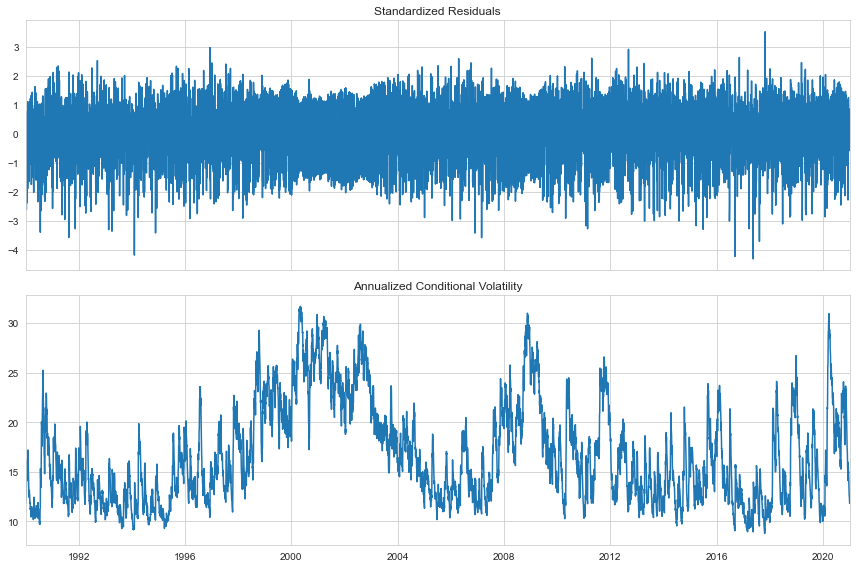

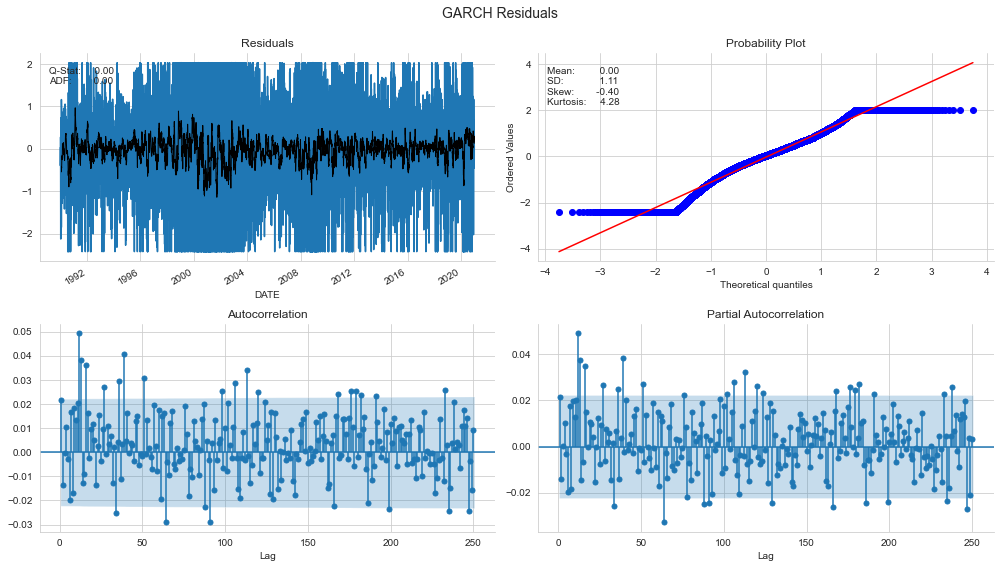

In [60]:
fig = best_model.plot(annualize='D')
fig.set_size_inches(12, 8)
fig.tight_layout()

utils.plot_correlogram(best_model.resid.dropna(),
                 lags=250,
                 title='GARCH Residuals')

## Multivariate time series models

Multivariate time series models are designed to capture the dynamic of multiple time series
simultaneously and leverage dependencies across these series for more reliable predictions. In addition to potentially better forecasting, multivariate time series are also used to gain
insights into cross-series dependencies. Furthermore, multivariate time series models allow for a decomposition of the
prediction error variance to analyze how other series contribute.  

the vector autoregressive VAR(p) model extends the AR(p) model to k
series by creating a system of k equations where each contains p lagged values of all k
series.

\begin{equation}
\underset{k \times 1}{y_{t}} = \underset{k\times1}c + \underset{k\times k}{A_1}\underset{k\times 1}{y_{t-1}} + \cdots + \underset{k\times k}{A_p}\underset{k\times 1}{y_{t-p}} + \underset{k\times 1}{\epsilon_t}
\end{equation}

The coefficients on the own lags provide information about the dynamics of the series itself,
whereas the cross-variable coefficients offer some insight into the interactions across the
series.

VAR(p) models also require stationarity, so that the initial steps from univariate time series
modeling carry over. First, explore the series and determine the necessary transformations,
then apply the Augmented Dickey-Fuller test to verify that the stationarity criterion is met
for each series and apply further transformations otherwise. It can be estimated with OLS
conditional on initial information or with maximum likelihood, which is equivalent for
normally-distributed errors but not otherwise.

If some or all of the k series are unit-root non-stationary, they may be co-integrated. This
extension of the unit root concept to multiple time series means that a linear combination of
two or more series is stationary and, hence, mean-reverting.

The determination of the lag order also takes its cues from the ACF and PACF for each
series but is constrained by the fact that the same lag order applies to all series. After model
estimation, residual diagnostics also call for a result resembling white noise, and model
selection can use in-sample information criteria or, preferably, out-of-sample predictive
performance to cross-validate alternative model designs if the ultimate goal is to use the
model for prediction.
As mentioned in the univariate case, predictions of the original time series require us to
reverse the transformations applied to make a series stationary before training the model.

We will extend the univariate example of a single time series of monthly data on industrial production and add a monthly time series on consumer sentiment, both provided by the Federal Reserve's data service.

In [4]:
df = web.DataReader(['UMCSENT','IPGMFN'],'fred','1970','2021-10').dropna()
df.columns = ['sentiment','ip']

In [5]:
df.tail()

,sentiment,ip
DATE,,
2021-04-01,88.3,98.5252
2021-05-01,82.9,99.2920
2021-06-01,85.5,100.9501
2021-07-01,81.2,98.6979
2021-08-01,70.3,101.8867


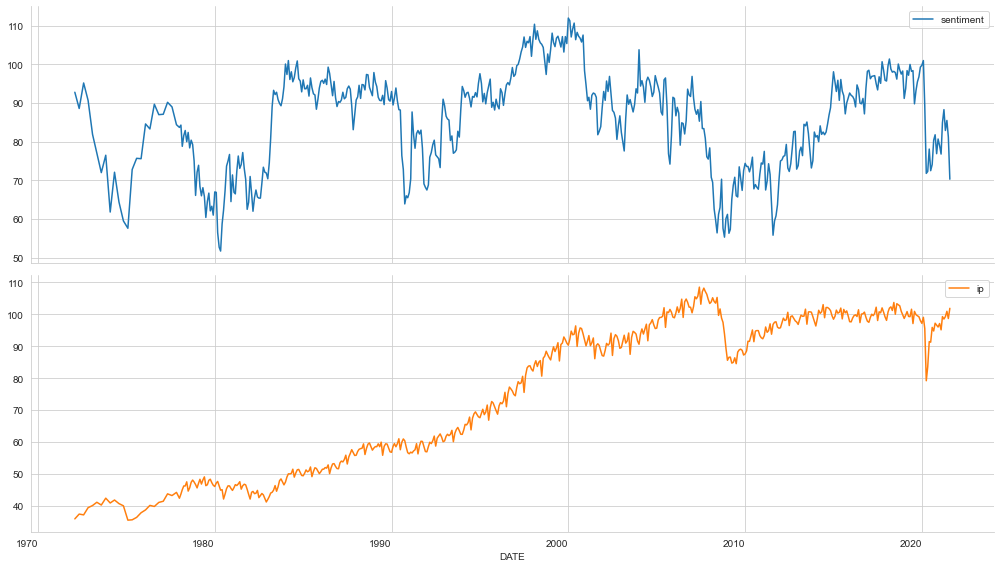

In [6]:
df.plot(subplots = True,figsize = (14,8),rot=0)
sns.despine()
plt.tight_layout()

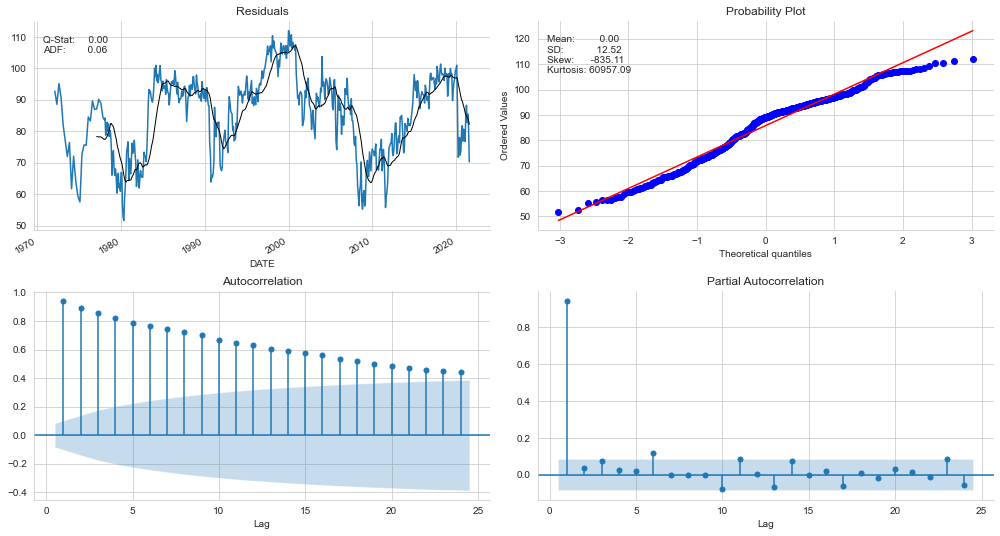

In [7]:
utils.plot_correlogram(df.sentiment,lags=24)

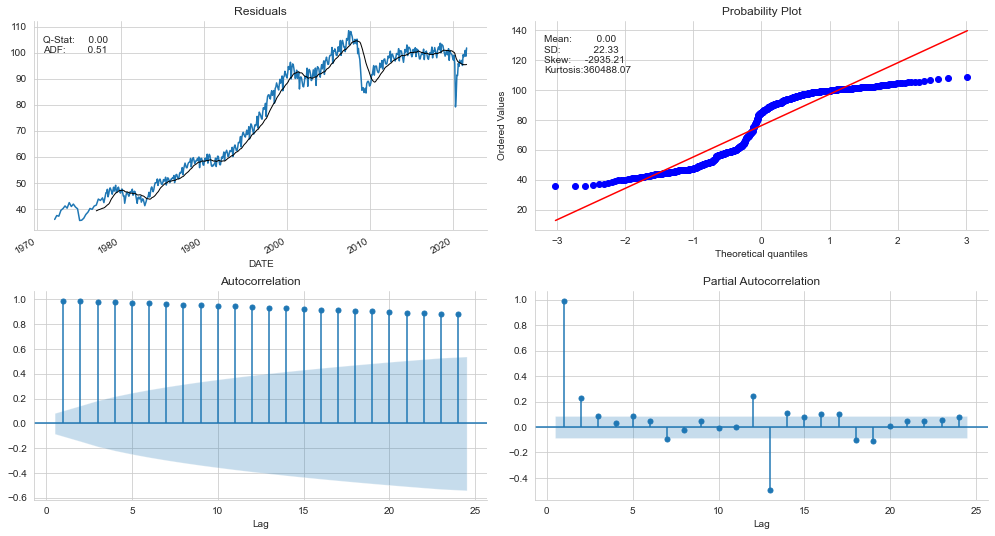

In [8]:
utils.plot_correlogram(df.ip,lags=24)

In [9]:
df_transformed = pd.DataFrame({'ip':np.log(df.ip).diff(12),'sentiment':df.sentiment.diff(12)}).dropna()

In [10]:
df_transformed

,ip,sentiment
DATE,,
1975-02-01,-0.011217,-35.2
1975-05-01,-0.049173,-15.8
1975-08-01,-0.021282,-19.5
1975-11-01,-0.041000,-15.1
1976-02-01,-0.034722,2.7
...,...,...
2021-04-01,0.218157,16.5
2021-05-01,0.171897,10.6
2021-06-01,0.098642,7.4


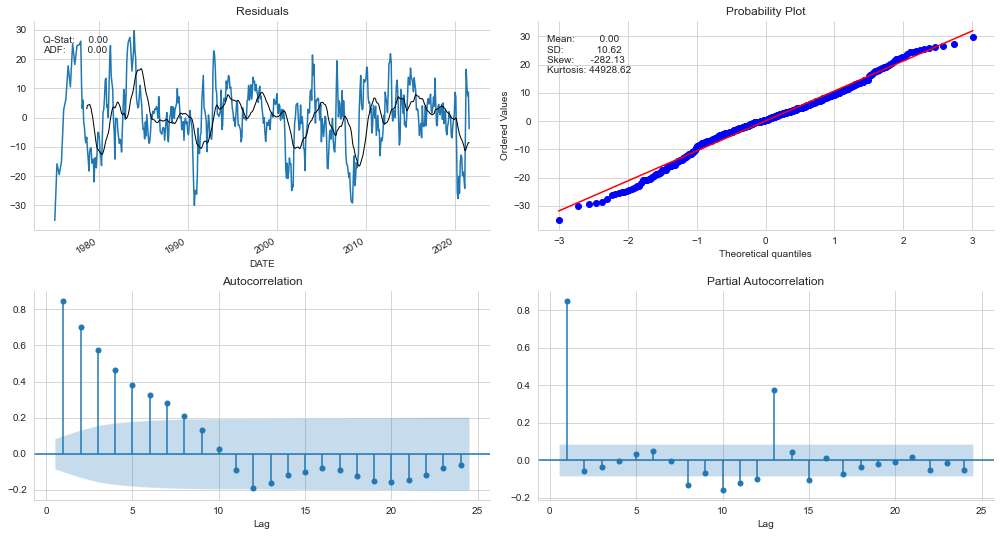

In [11]:
utils.plot_correlogram(df_transformed.sentiment,lags=24)

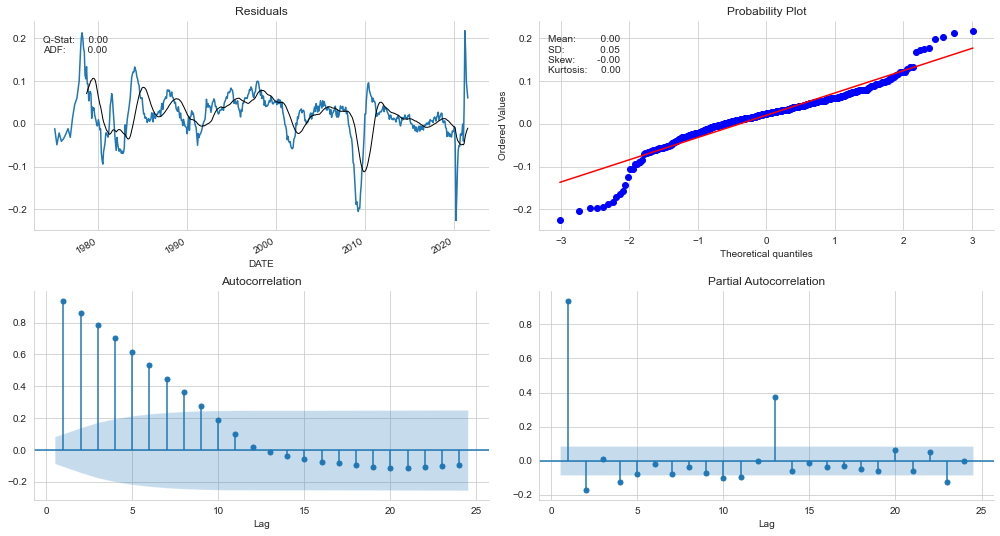

In [12]:
utils.plot_correlogram(df_transformed.ip,lags=24)

In [13]:
utils.unit_root_test(df_transformed)

,p-value
ip,0.04%
sentiment,0.00%


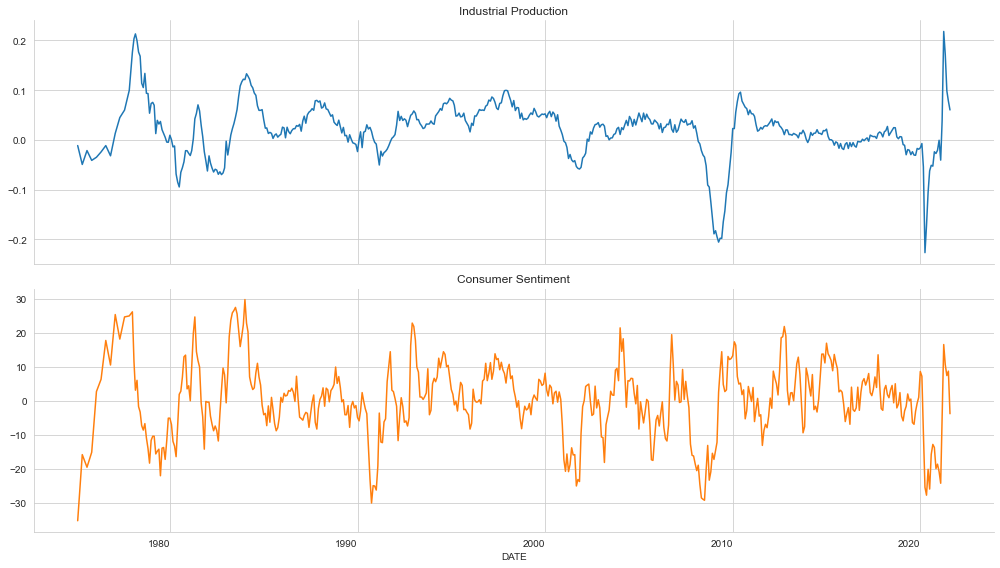

In [14]:
df_transformed.plot(subplots=True, figsize=(14, 8),
                    title=['Industrial Production', 'Consumer Sentiment'],
                    legend=False,
                    rot=0)
sns.despine()
plt.tight_layout()

In [16]:
import matplotlib.transforms as mtransforms
from statsmodels.tsa.api import VARMAX
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import minmax_scale
from scipy.stats import probplot, moment
from sklearn.metrics import mean_absolute_error

sns.set(style='whitegrid',
        context='notebook',
        color_codes=True)

### VAR Model

In [24]:
df_transformed = df_transformed.apply(minmax_scale)
model = VARMAX(df_transformed.loc[:'2021'],order=(1,1),trand='c').fit(maxiter=100) # constant trend through 2021

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [20]:
model.summary()

Dep. Variable:,"['ip', 'sentiment']",No. Observations:,536
Model:,"VARMA(1,1)",Log Likelihood,1543.138
,+ intercept,AIC,-3060.276
Date:,"Mon, 11 Oct 2021",BIC,-3004.582
Time:,10:31:58,HQIC,-3038.487
Sample:,0,,
,- 536,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.00, 0.31",Jarque-Bera (JB):,"18468.71, 14.63"
Prob(Q):,"0.97, 0.57",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"2.15, 1.00",Skew:,"0.31, 0.19"


Let's check whether the residuals meet the white noise assumptions

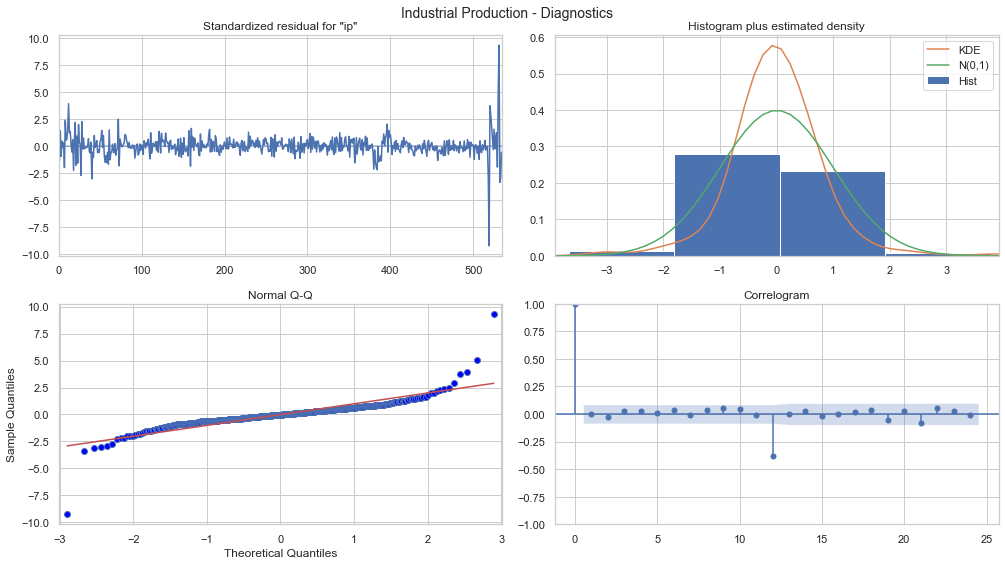

In [25]:
model.plot_diagnostics(variable=0,figsize=(14,8),lags=24)
plt.gcf().suptitle('Industrial Production - Diagnostics',fontsize = 14)
plt.tight_layout()
plt.subplots_adjust(top=.93)

Text(0.5, 0.98, 'Sentiment - Diagnostics')

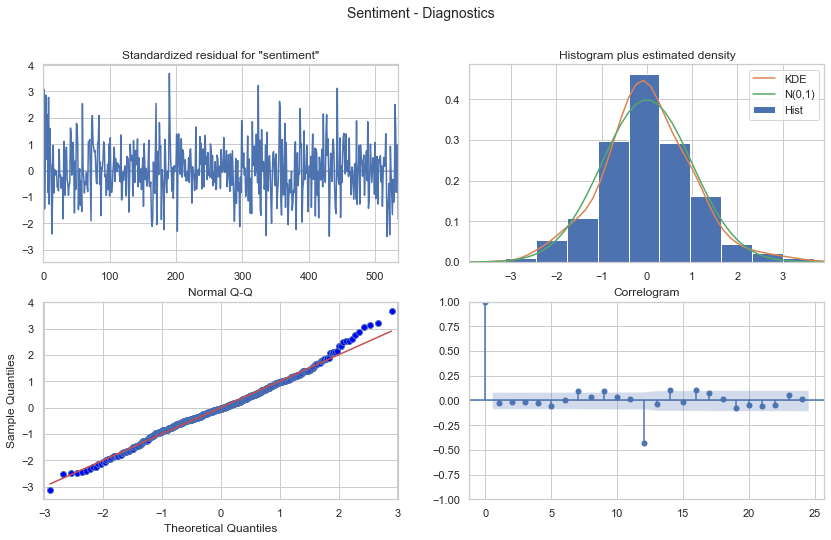

In [28]:
model.plot_diagnostics(variable=1, figsize=(14,8), lags=24)
plt.gcf().suptitle('Sentiment - Diagnostics',fontsize = 14)

residuals are not exactly white noise in this case